In [5]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os

# dir = '../test_batch_output'
dir ='../../NeuronSet2/Random_Cells/surface_meshes'

In [6]:
log_file = f'{dir}/mesh_stats.db'

conn = sqlite3.connect(log_file)
data = pd.read_sql_query('SELECT * FROM meshing_stats',conn)

In [7]:
data

,morphology,vertex_number,face_number,surface_area,volume,alpha_vertex_number,alpha_face_number,alpha_surface_area,alpha_volume,mesh_quality,cleaned_swc_nodes,extract_swc,reorder_swc,process_swc,initialise_branches,initialising_individual_meshes,merging_individual_meshes,alpha_wrap,simplify_mesh,tetgen
0,PVN27_microglia28.CNG,5687,11386,2326.212158,1342.773657,130498,261008,2342.525879,1350.780598,0.800913,1107,0.009891,0.019157,1.205313,0.000000,0.730134,0.340070,72.668318,29.619990,0.425
1,Anstoetz_Toolbox-IN4.CNG,15975,31970,6255.673828,6357.831770,602435,1204890,6235.583984,6380.464230,0.468554,11783,0.015583,0.028852,8.745593,0.095330,8.754163,0.406960,903.323802,338.629369,7.531
2,sc147_r270x_12.CNG,394,788,145.553040,7.327686,10582,21164,149.780426,7.936067,0.752886,195,0.006696,0.004003,0.096557,0.000000,0.224373,0.041388,5.798627,1.299572,0.072
3,WvHMM12_18DIV_cs_88_c__3_MMStack_Pos0-ome_PSD9...,3198,6404,3088.376465,2883.882412,184389,368786,3099.134521,2898.582513,0.903190,1592,0.019850,0.046296,4.184906,0.000000,1.276652,0.108445,134.297867,58.506831,1.087
4,cell-185-trace.CNG,6416,12832,7413.971191,3455.574825,362702,725404,7368.982422,3485.267636,0.642133,4925,0.005181,0.008634,1.548572,0.031247,1.136407,0.133950,203.597609,100.924886,0.758
5,H9-MECP2-T158M-T158M-Untreated-45.CNG,726,1452,1013.725952,1890.480790,104315,208630,1026.050049,1915.666248,0.650495,504,0.000998,0.001560,0.013454,0.000000,0.319504,0.040984,59.874450,29.777438,0.111
6,fru-F-700195.CNG,2104,4204,3004.872314,694.180049,14830,29656,3052.742920,726.703877,0.575029,1445,0.001755,0.002046,0.133124,0.000000,0.593211,0.084275,12.176692,1.748521,0.150
7,fru-F-700196.CNG,2726,5452,3870.235596,877.240038,19819,39638,3959.950439,943.273233,0.572132,1941,0.003009,0.004612,0.246731,0.007286,0.527511,0.098457,13.580285,1.877207,0.195
8,C2-Tipo-III-1.CNG,492,996,1295.053833,753.104543,4415,8842,1681.167236,1079.450560,0.636883,249,0.005305,0.007130,0.124132,0.000000,0.117957,0.040117,1.665717,0.214479,0.016
9,13-C3-ddaA.CNG,7463,15158,9830.525391,2114.259740,107116,214464,10192.253906,2277.501978,0.742892,4017,0.028505,0.116965,13.351731,0.022339,3.427650,0.999941,64.455177,16.009951,1.098


In [21]:
swc_timings = np.sum(np.array([data[key] for key in ['extract_swc','reorder_swc','process_swc','initialise_branches']]),axis=0)
individual_mesh_timings =  np.sum(np.array([data[key] for key in ['initialising_individual_meshes','merging_individual_meshes']]),axis=0)
alpha_wrap_timings = np.array( data['alpha_wrap'])
simplify_timings = np.array( data['simplify_mesh'])
tetgen_timings = np.array( data['tetgen'])
cells = list(data['morphology'])

In [22]:
df = pd.DataFrame({'label':cells,'swc':swc_timings,'individual meshes':individual_mesh_timings,'alpha wrapping':alpha_wrap_timings,'mesh simplification':simplify_timings,'tetgen':tetgen_timings})

In [23]:
df.swc + df['individual meshes'] + df['alpha wrapping'] + df['mesh simplification']

0      26.405513
1     821.090292
2     134.408623
3    1005.442755
4     422.056933
5     334.468685
6     221.434152
dtype: float64

<Figure size 640x480 with 0 Axes>

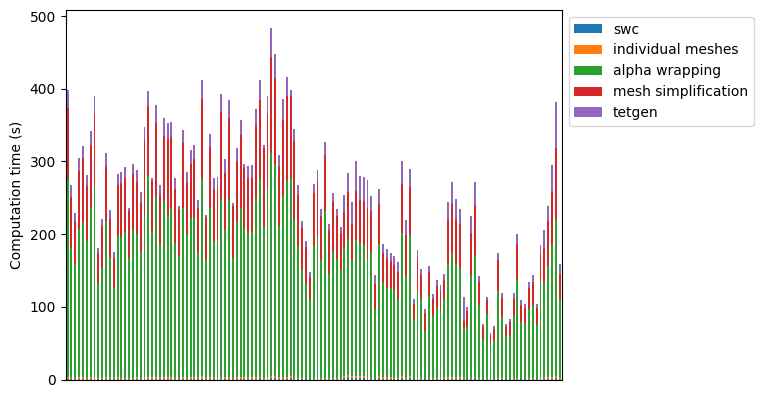

In [6]:
fig = plt.figure()
df.plot(kind='bar',stacked=True,rot=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
    )
plt.ylabel('Computation time (s)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),ncol=1, fancybox=True, shadow=False)
plt.show()

<Figure size 640x480 with 0 Axes>

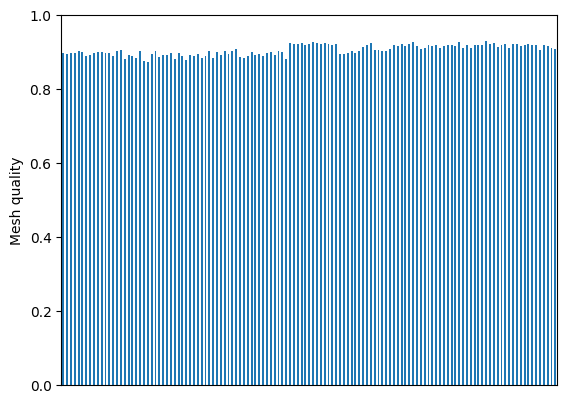

In [7]:
fig = plt.figure()
data.plot(y='mesh_quality',kind='bar',stacked=True,rot=0,legend=None)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Mesh quality')
plt.ylim(0,1)
plt.show()


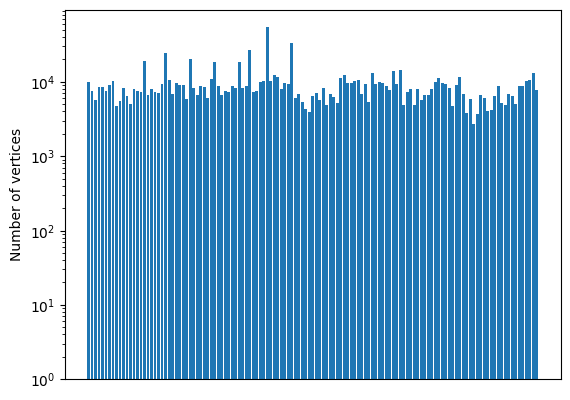

In [9]:
fig,ax = plt.subplots()
ax.bar(np.arange(0,len(data['vertex_number'])),np.array(data['vertex_number']),bottom=1)
ax.set_yscale('log')
ax.set_ylabel('Number of vertices')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [10]:
from ..src import Swc

In [16]:
complexity = []
for cell in cells:
    # swc = Swc(f'time_input/{cell}.swc',False)
    # swc = Swc(f'../alphaSwc_data/swc_files3/{cell}.swc',False)
    swc = Swc(f'../alphaSwc_data/microglial_input/balleine_CNG_version/{cell}.swc',False)

    Nb = len(np.unique(swc.branches)) - 1
    rmax = max(swc.radius_data)
    rmin = min(swc.radius_data)
    complexity.append(Nb*rmax/rmin)
    

Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc
Reordering swc


In [13]:
total_time = np.sum(np.array(df)[:,1:],axis=1)

In [14]:
total_time

array([26.462513048171996, 822.7872917385101, 134.59562250328065,
       1012.4307547454835, 422.6369334030151, 334.8706846733093],
      dtype=object)

In [12]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def get_regr_stats(x,y,normalize = True,xlabel=None,ylabel=None):
    x = np.array(x)
    y = np.array(y)
    if normalize:
        std_x = ((x - np.mean(x))/np.std(x)).reshape(-1,1)
        std_y = ((y - np.mean(y))/np.std(y)).reshape(-1,1)
    else:
        std_x = x.reshape(-1,1)
        std_y = y.reshape(-1,1)

    reg = linear_model.LinearRegression()
    reg.fit(std_x,std_y)
    a = reg.coef_
    std_y_predicted = reg.predict(std_x)
    print("Mean squared error: %.2f" % mean_squared_error(std_y, std_y_predicted))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(std_y, std_y_predicted))
    std_error = np.sqrt(mean_squared_error(std_y, std_y_predicted))
    fig = plt.figure()
    plt.scatter(std_x,std_y)
    plt.plot(std_x,std_y_predicted,'r')
    # plt.plot(std_complexity,std_time_predicted +std_error,'g')
    # plt.plot(std_complexity,std_time_predicted -std_error,'g',)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

Number of nodes
Mean squared error: 4799.94
Coefficient of determination: 0.45


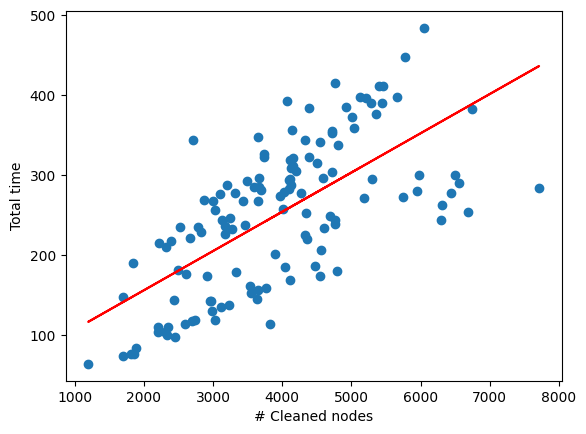

Surface area
Mean squared error: 0.93
Coefficient of determination: 0.07


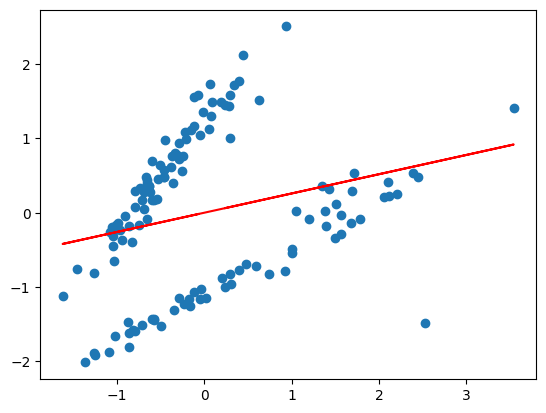

In [14]:
# print('Complexity')
# get_regr_stats(complexity,total_time)
print('Number of nodes')
get_regr_stats(data.cleaned_swc_nodes,total_time,normalize=False,xlabel='# Cleaned nodes',ylabel='Total time')
print('Surface area')
get_regr_stats(data.surface_area,total_time)